In [1]:
from selenium import webdriver # 웹 크롤링 모듈
from bs4 import BeautifulSoup # 객체구조 변환 모듈
from collections import Counter # 빈도수 모듈
from wordcloud import WordCloud # 빈도수 별 나열 모듈
from multiprocessing import Process, Queue # 멀티프로세싱 모듈
import matplotlib.pyplot as plt # 시각화 모듈
import time # sleep을 주기 위한 모듈
import csv # csv파일 저장 모듈
%matplotlib inline

class instagram_Hashtag_Crawler:
    """
        인스타그램 해시태그 데이터 수집
    """
    def follow_Crawling(self, path = '/Users/markmac/Downloads/chromedriver'): # 팔로우한 계정 크롤링
        """
            팔로우 계정 수집
            
            path: 크롬드라이버 설치 위치
        """
        self.path = path # Chrome Webdriver Path
        
        account_id = [] # 계정 ID 넣을 list
        
        driver = webdriver.Chrome(path) # Chrome webdriver path
        driver.get('https://www.instagram.com') # 사이트 주소
        time.sleep(1) # 1초 슬립
        
        driver.find_element_by_css_selector('p.izU2O > a').click() # 인스타그램 로그인 버튼 클릭
        time.sleep(1)
        
        driver.find_element_by_name('username').send_keys('hashtagcrawler@gmail.com') # 계정 ID 입력
        driver.find_element_by_name('password').send_keys('dkdlel12') # 계정 Password 입력
        
        driver.find_element_by_xpath("//button[@class = '_0mzm- sqdOP  L3NKy       ']").click() # 로그인 하기 버튼 클릭
        time.sleep(1) # 3초 슬립
        
        #driver.find_element_by_xpath("//button[@class = 'aOOlW  bIiDR  ']").click() # 알림 설정 버튼 클릭
        driver.find_element_by_xpath("//span[@class = 'glyphsSpriteUser__outline__24__grey_9 u-__7']").click() # 내 정보 클릭
        time.sleep(2) # 4초 슬립
        
        driver.find_elements_by_css_selector('a.-nal3 ')[1].click() # 팔로우 버튼 클릭
        time.sleep(1)
        
        scroll = driver.find_element_by_class_name('isgrP') # 스크롤 범위
        driver.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight", scroll) # 스크롤 맨 밑으로 내리기
        time.sleep(1)
        
        # 스크롤 절반 올리기
        jsScript = """
        function move_up(element) {
            element.scrollTop = element.scrollTop - 500;
        }

        function move_down(element) {
            console.log('Position before: ' + element.scrollTop);
            element.scrollTop = element.scrollTop + 1000;
            console.log('Position after: ' + element.scrollTop);
        }

        move_up(arguments[0]);
        """
        
        driver.execute_script(jsScript, scroll) # 스크롤 절반 올리기
        time.sleep(1)
        
        # 스크롤 다시 계속 내리기
        try:
            for i in range(10): # 스크롤 10번 내림
                driver.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight", scroll)
                time.sleep(2)
        except:
            print('error')
            
        time.sleep(1)
        
        html = driver.page_source # Html 소스코드 가져오기
        dom = BeautifulSoup(html, 'html.parser') # BeautifulSoup 모듈로 Html 객체구조 변환
            
        account_id_list = driver.find_elements_by_xpath("//a[@class = 'FPmhX notranslate _0imsa ']") # 계정 ID 경로
        
        account_id = [j.text for j in account_id_list] # 계정 ID 경로 텍스트로 리스트 삽입
            
        driver.close() # 브라우져 종료
            
        return account_id
    
    def hashtag_Crawling(self, account_id_lists, is_date, output, path = '/Users/markmac/Downloads/chromedriver'):
        """
            수집한 팔로우 계정을 이용해 해시태그 수집
        """
        self.account_id_lists = account_id_lists # 계정 ID
        self.is_date = is_date # 크롤링 할 날짜
        self.output = output
        self.path = path # Chrome Webdriver Path
        
        tag_data = [] # 해시태그 소스코드 저장
        words = [] # 텍스트로 추출 후 저장
        words_list = [] # 해시태그만 저장
        
        for i in range(len(account_id_lists)):
            driver = webdriver.Chrome(path) # Chrome Webdriver Path
            driver.get('https://www.instagram.com/' + account_id_lists[i]) # 인스타그램 계정 URL
            
            driver.find_element_by_xpath("//div[@class = '_9AhH0']").click() # 계정 첫번째 게시물 클릭
            
            while True:
                try:
                    time.sleep(2) # 3초 슬립
                    html = driver.page_source # Html 소스 코드 가져오기
                    dom = BeautifulSoup(html, 'html.parser') # BeautifulSoup 모듈로 Html 객체구조 변환
                    
                    date = driver.find_element_by_class_name('_1o9PC').get_attribute('title')[:8] # 게시물 날짜 년, 월까지만 크롤링
                    
                    if is_date == date: # 게시물 날짜가 입력날짜와 같으면 실행
                        tag_data += dom.select('div.C4VMK > span > a') # 해시태그 저장
                        
                        driver.find_element_by_xpath("//a[@class = 'HBoOv coreSpriteRightPaginationArrow']").click() # 다음 버튼 클릭
                    else: # 날짜가 다르면
                        driver.find_element_by_xpath("//a[@class = 'HBoOv coreSpriteRightPaginationArrow']").click() # 다음 버튼 클릭
                except:
                    driver.close() # 브라우져 종료
                    break
                    
            time.sleep(1)
            
        words = [j.text for j in tag_data]# 텍스트로 추출
            
        words_list = [x for x in words if x[0] == '#'] # 해시태그와 계정태그 중 해시태그만 추출
                
        output.put(words_list)
    
    def save_csv(self, date, tags):
        """
            수집한 해시태그 데이터 CSV파일로 저장
        """
        self.date = date # csv파일 저장 이름
        self.tags = tags # 해시태그 데이터
        
        tc = Counter(tags) # 빈도수
        tags_count = dict(tc) # 딕셔너리 구조로 바꿈
        
        with open(date + '_instagram_Hashtag.csv', 'w', encoding = 'utf-8', newline = '') as f: # csv파일 저장
            header = ['해시태그', '빈도수']
            writer = csv.DictWriter(f, fieldnames = header)
            
            writer.writeheader()
            
            [writer.writerow({'해시태그' : i, '빈도수' : j}) for i, j in tags_count.items()]
                
    def wordcloud_Plot(self, words_list, save_file_name):
        """
            해시태그 데이터 시각화
        """
        self.words_list = words_list # 해시태그 리스트
        self.save_file_name = save_file_name # wordcloud 저장 이름
        
        with open('/Users/markmac/Downloads/wordcloud_data.txt', 'w') as f:
            [f.write(words_list[i] + '\n') for i in range(len(words_list))]
        
        text = open('/Users/markmac/Downloads/wordcloud_data.txt').read()
        # 워드클라우드로 변환
        wordcloud = WordCloud(max_font_size = 30, font_path = '/Users/markmac/Fonts/NanumSquareBold.ttf', background_color = 'white').generate(text)
        
        plt.figure(figsize = (40, 40)) # 시각화 사이즈
        plt.imshow(wordcloud, interpolation = 'bilinear') # 시각화 종류
        plt.axis('off') # x, y축 이름 제거
        plt.savefig(save_file_name) # 저장

In [2]:
instagram = instagram_Hashtag_Crawler()

In [3]:
account_id_lists = instagram.follow_Crawling()

In [4]:
account_id_lists

['jayflowsik',
 'killagramz3xl',
 'chachamalone',
 'boycold_',
 'uglyduck062',
 'wavycolde',
 'woogie_park',
 'longlivesmdc',
 'anythinggoes85',
 'coogie0123',
 'hwimmm',
 'yunbnotlilb',
 'supergreathurricane',
 'drunkentigerjk',
 'g2slife',
 'gaekogeem',
 'nucksal',
 'penomadeincorea',
 'keemhongwu',
 'huckleberryp84',
 'deepflow39',
 'superstarjimmyfuckedup',
 'originalgimchi',
 'hiolnl',
 'dprlive',
 'crush9244',
 'satgotloco',
 'junoflo',
 'woodie_gochild',
 'younghotyellow94',
 'code_kunst',
 'bewhy.meshasoulja',
 'nasungcityboy',
 'wejustmusic',
 'thisloop',
 'jparkitrighthere',
 'hashblanccoa',
 'callmegray',
 'aomgofficial',
 'ph1boyyy',
 'paloaltongue',
 'woozico0914',
 'thequiett',
 'munchinthepool',
 'dok2gonzo',
 'noahmik',
 'realllllmino',
 'kiff_websterb',
 'changmo_',
 'itsjustswings',
 'kidcozyboy',
 'noelcozyboy',
 'yohanheaven',
 'osshun_gum',
 'jvckiwai',
 'hankyungsoo',
 'giriboy91']

In [5]:
len(account_id_lists)

57

In [6]:
account_id_lists_1 = []
account_id_lists_2 = []
account_id_lists_3 = []
account_id_lists_4 = []
account_id_lists_5 = []
account_id_lists_6 = []

account_id_lists_1 += account_id_lists[:9]
account_id_lists_2 += account_id_lists[9:18]
account_id_lists_3 += account_id_lists[18:28]
account_id_lists_4 += account_id_lists[28:38]
account_id_lists_5 += account_id_lists[38:48]
account_id_lists_6 += account_id_lists[48:57]

In [7]:
account_id_lists_1

['jayflowsik',
 'killagramz3xl',
 'chachamalone',
 'boycold_',
 'uglyduck062',
 'wavycolde',
 'woogie_park',
 'longlivesmdc',
 'anythinggoes85']

In [8]:
account_id_lists_2

['coogie0123',
 'hwimmm',
 'yunbnotlilb',
 'supergreathurricane',
 'drunkentigerjk',
 'g2slife',
 'gaekogeem',
 'nucksal',
 'penomadeincorea']

In [9]:
account_id_lists_3

['keemhongwu',
 'huckleberryp84',
 'deepflow39',
 'superstarjimmyfuckedup',
 'originalgimchi',
 'hiolnl',
 'dprlive',
 'crush9244',
 'satgotloco',
 'junoflo']

In [10]:
account_id_lists_4

['woodie_gochild',
 'younghotyellow94',
 'code_kunst',
 'bewhy.meshasoulja',
 'nasungcityboy',
 'wejustmusic',
 'thisloop',
 'jparkitrighthere',
 'hashblanccoa',
 'callmegray']

In [11]:
account_id_lists_5

['aomgofficial',
 'ph1boyyy',
 'paloaltongue',
 'woozico0914',
 'thequiett',
 'munchinthepool',
 'dok2gonzo',
 'noahmik',
 'realllllmino',
 'kiff_websterb']

In [12]:
account_id_lists_6

['changmo_',
 'itsjustswings',
 'kidcozyboy',
 'noelcozyboy',
 'yohanheaven',
 'osshun_gum',
 'jvckiwai',
 'hankyungsoo',
 'giriboy91']

In [ ]:
if __name__ == '__main__':
    output1 = Queue()
    output2 = Queue()
    output3 = Queue()
    output4 = Queue()
    output5 = Queue()
    output6 = Queue()
    
    temp = []
    procs = []
    procs.append(Process(target = instagram.hashtag_Crawling, args = (account_id_lists_1, '2018년 9월', output1)))
    procs.append(Process(target = instagram.hashtag_Crawling, args = (account_id_lists_2, '2018년 9월', output2)))
    procs.append(Process(target = instagram.hashtag_Crawling, args = (account_id_lists_3, '2018년 9월', output3)))
    procs.append(Process(target = instagram.hashtag_Crawling, args = (account_id_lists_4, '2018년 9월', output4)))
    procs.append(Process(target = instagram.hashtag_Crawling, args = (account_id_lists_5, '2018년 9월', output5)))
    procs.append(Process(target = instagram.hashtag_Crawling, args = (account_id_lists_6, '2018년 9월', output6)))
    
    for p in procs:
        p.start()
        
    temp += output1.get()
    temp += output2.get()
    temp += output3.get()
    temp += output4.get()
    temp += output5.get()
    temp += output6.get()
    
    for p in procs:
        p.join()

In [16]:
len(temp)

454

In [16]:
instagram.save_csv('2018_9', temp)

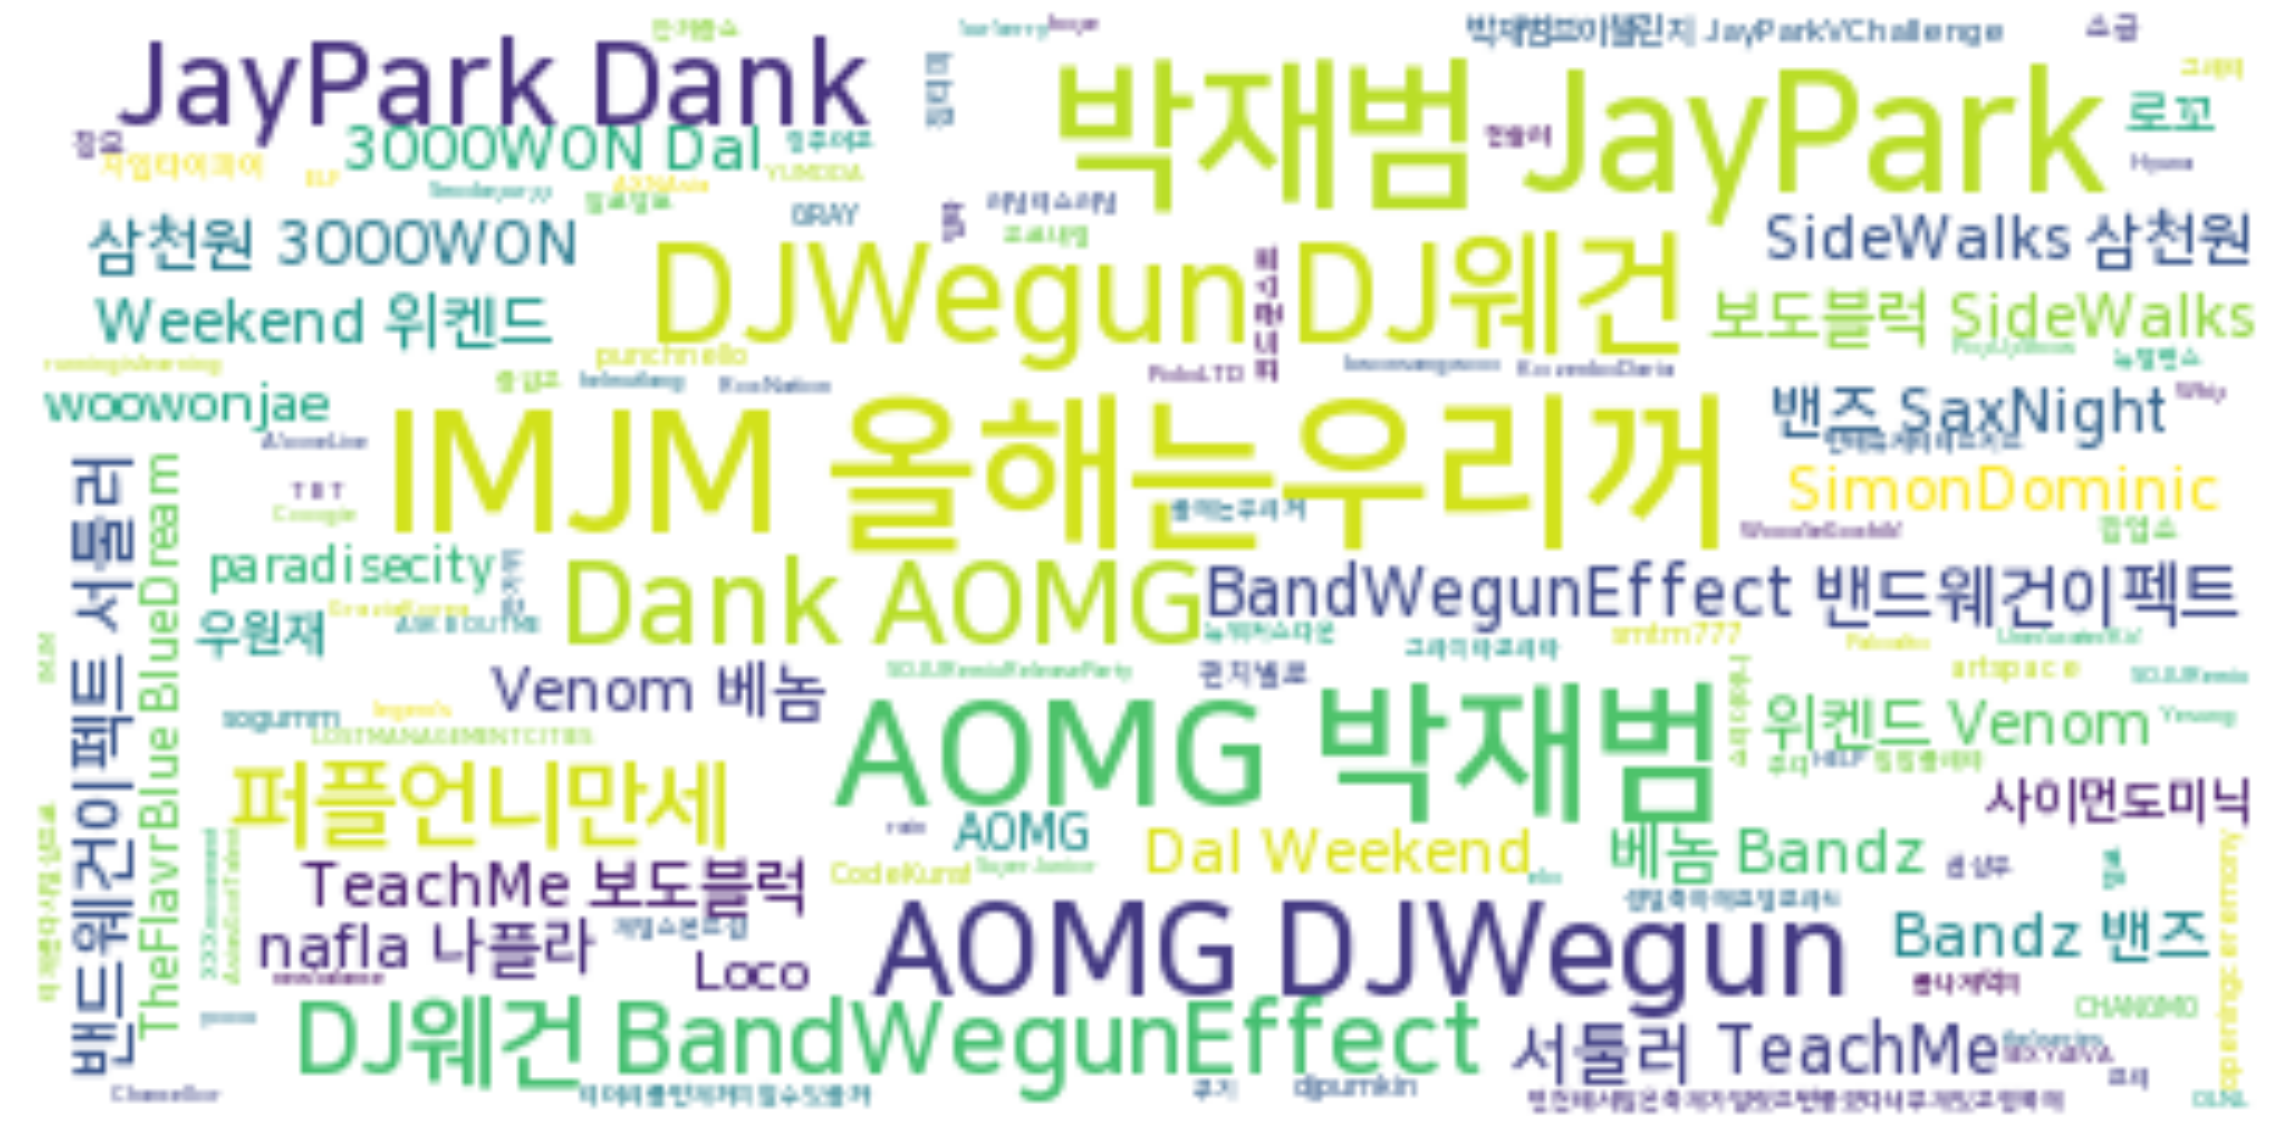

In [17]:
instagram.wordcloud_Plot(temp, 'instagram_wordcloud_2018_9')